# The Battle of Neighborhoods

# Introduction

There are many famous and rich heritage countries in the world which attracts a lot of people to immigrate to them. One such city is New York. Thus , there you can find variety of people with different languages and cuisine of course. One such majority of people there include people from India. Though you change your country you always are in search of your country food and you would love to reside in such a place where you can get access to it. So , in this project we will try to visualize the city of New York to find the best Indian Cuisine serving places. We will try to find the best location in New York City for Indian Cuisine and the areas where there is a deficiency of such places.

# Data

For this capstone I will use the same dataset of New York city which contains Boroughs, Neighborhoods along with their latitude and longitude. Data source can be found at https://cocl.us/new_york_dataset . Indian resturants in each neighborhood of new york city can be found using the Foursquare API.By using this API we will get all the venues in each neighborhood.We will also use geospace data, by using this geo space data we will get the New york Borough boundaries that will help us visualize choropleth map.The geodata set can be found at https://data.cityofnewyork.us/City-Government/Borough-Boundaries/tqmj-j8zm for the borough boundaries. So first we will collect the new york city data from https://cocl.us/new_york_dataset , then by using FourSquare API we will find all venues for each neighborhood and filter out all venues that are Indian Restaurants. Then we can find rating , tips and like count for each Indian Resturants using FourSquare API using which we will sort that data and visualize the ranking of neighborhoods using folium library.

# Analysis

First we install several packages.

In [4]:
import sys
!{sys.executable} -m pip install geocoder

     |████████████████████████████████| 102kB 12.1MB/s ta 0:00:01


In [6]:
import sys
!{sys.executable} -m pip install folium

     |████████████████████████████████| 92kB 10.0MB/s eta 0:00:01


In [7]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import requests
from bs4 import BeautifulSoup
import geocoder
import os
import folium 
from geopy.geocoders import Nominatim 
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline


print('Libraries imported.')

Libraries imported.


In [8]:
def geo_location(address):
    
    geolocator = Nominatim(user_agent="ny_explorer")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return latitude,longitude

We will define a function to intract with FourSquare API and get top 100 venues within a radius of 1000 metres for a given latitude and longitude. Below function will return us the venue id , venue name and category.

In [24]:
def get_venues(lat,lng):
    
    
    radius=1000
    LIMIT=100
    CLIENT_ID = os.environ['HQABMC040UWY1NDWWFFDR5W5GWL5XCK5ZX3NPR4A0IFHFE4T'] 
    CLIENT_SECRET = os.environ['2KBKLKEO33JKY0KUTQPSS5XSLDZLMNFCKBDYHUAFIFXZZWIX'] 
    VERSION = '20180605' 
    
    
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
    
    
    results = requests.get(url).json()
    venue_data=results["response"]['groups'][0]['items']
    venue_details=[]
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
        
    column_names=['ID','Name','Category']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

Now we will get the details like count, rating , etc.

In [10]:
def get_venue_details(venue_id):
        
    CLIENT_ID = os.environ['HQABMC040UWY1NDWWFFDR5W5GWL5XCK5ZX3NPR4A0IFHFE4T'] 
    CLIENT_SECRET = os.environ['2KBKLKEO33JKY0KUTQPSS5XSLDZLMNFCKBDYHUAFIFXZZWIX'] 
    VERSION = '20180605' 
    
    
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    
    
    results = requests.get(url).json()
    venue_data=results['response']['venue']
    venue_details=[]
    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_tips=venue_data['tips']['count']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        pass
        
    column_names=['ID','Name','Likes','Rating','Tips']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

Now we will extract New York City dataset.

In [11]:
def get_new_york_data():
    url='https://cocl.us/new_york_dataset'
    resp=requests.get(url).json()
    features=resp['features']
    
    
    column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
    
    new_york_data = pd.DataFrame(columns=column_names)
    
    for data in features:
        borough = data['properties']['borough'] 
        neighborhood_name = data['properties']['name']
        
        neighborhood_latlon = data['geometry']['coordinates']
        neighborhood_lat = neighborhood_latlon[1]
        neighborhood_lon = neighborhood_latlon[0]
    
        new_york_data = new_york_data.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
    
    return new_york_data

In [12]:
new_york_data=get_new_york_data()

In [13]:
new_york_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [14]:
new_york_data.shape

(306, 4)

There are 306 such places.

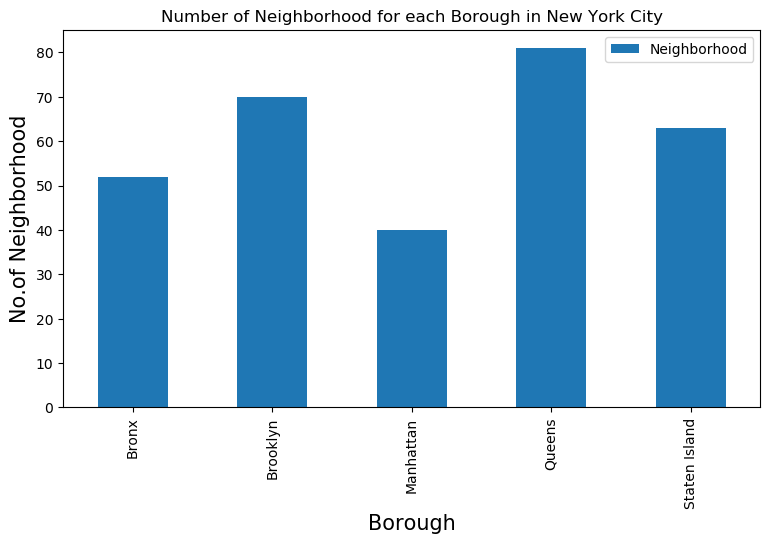

In [15]:
plt.figure(figsize=(9,5), dpi = 100)
plt.title('Number of Neighborhood for each Borough in New York City')
plt.xlabel('Borough', fontsize = 15)
plt.ylabel('No.of Neighborhood', fontsize=15)
new_york_data.groupby('Borough')['Neighborhood'].count().plot(kind='bar')
plt.legend()
plt.show()

I guess Queens is most famous.

Now lets check for some Indian Restaurants.

In [18]:
column_names=['Borough', 'Neighborhood', 'ID','Name']
indian_rest_ny=pd.DataFrame(columns=column_names)
count=1

In [28]:
for row in new_york_data.values.tolist():
    Borough, Neighborhood, Latitude, Longitude=row
    venues = get_venues(Latitude,Longitude)
    indian_resturants=venues[venues['Category']=='Indian Restaurant']   
    print('(',count,'/',len(new_york_data),')','Indian Resturants in '+Neighborhood+', '+Borough+':'+str(len(indian_resturants)))
    for resturant_detail in indian_resturants.values.tolist():
        id, name , category=resturant_detail
        indian_rest_ny = indian_rest_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name
                                               }, ignore_index=True)
    count+=1

KeyError: 'HQABMC040UWY1NDWWFFDR5W5GWL5XCK5ZX3NPR4A0IFHFE4T'

In [21]:
indian_rest_ny.head()

,Borough,Neighborhood,ID,Name


TypeError: Empty 'DataFrame': no numeric data to plot

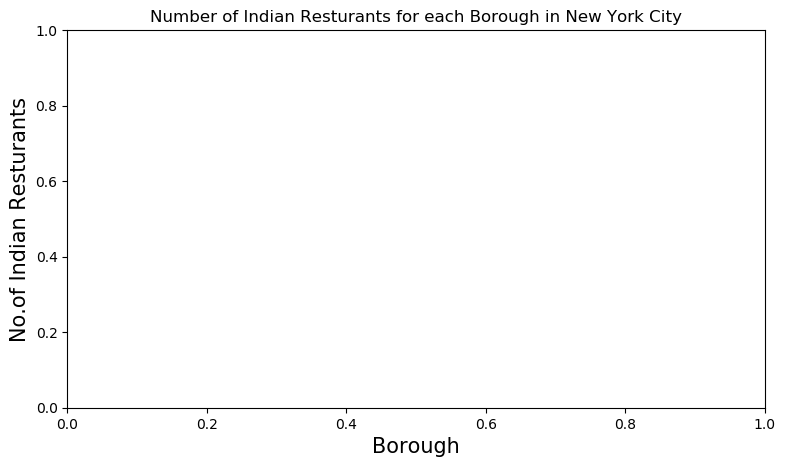

In [26]:
plt.figure(figsize=(9,5), dpi = 100)
plt.title('Number of Indian Resturants for each Borough in New York City')
plt.xlabel('Borough', fontsize = 15)
plt.ylabel('No.of Indian Resturants', fontsize=15)
indian_rest_ny.groupby('Borough')['ID'].count().plot(kind='bar')
plt.legend()
plt.show()

In [29]:
indian_rest_ny[indian_rest_ny['Neighborhood']=='Floral Park']

,Borough,Neighborhood,ID,Name


In [30]:
column_names=['Borough', 'Neighborhood', 'ID','Name','Likes','Rating','Tips']
indian_rest_stats_ny=pd.DataFrame(columns=column_names)
count=1


for row in indian_rest_ny.values.tolist():
    Borough,Neighborhood,ID,Name=row
    try:
        venue_details=get_venue_details(ID)
        print(venue_details)
        id,name,likes,rating,tips=venue_details.values.tolist()[0]
    except IndexError:
        print('No data available for id=',ID) 
        
        id,name,likes,rating,tips=[0]*5
    print('(',count,'/',len(indian_rest_ny),')','processed')
    indian_rest_stats_ny = indian_rest_stats_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name,
                                                'Likes' : likes,
                                                'Rating' : rating,
                                                'Tips' : tips
                                               }, ignore_index=True)
    count+=1

In [31]:
indian_rest_stats_ny.head()

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips


In [32]:
indian_rest_stats_ny.shape

(0, 7)

In [33]:
indian_rest_ny.shape

(0, 4)

In [34]:
indian_rest_stats_ny.to_csv('indian_rest_stats_ny.csv', index=False)

In [35]:
indian_rest_stats_ny_csv=pd.read_csv('indian_rest_stats_ny.csv')

In [36]:
indian_rest_stats_ny_csv.shape

(0, 7)

In [37]:
ny_map = folium.Map(location=geo_location('New York'), zoom_start=12)

In [38]:
incidents = folium.map.FeatureGroup()

for lat, lng, in ny_neighborhood_stats[['Latitude','Longitude']].values:
    incidents.add_child(
        folium.CircleMarker(
            [lat, lng],
            radius=10, 
            color='yellow',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6
        )
    )

NameError: name 'ny_neighborhood_stats' is not defined